In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
import sqlite3
from scipy import integrate
import matplotlib.cm as cm

import warnings

In [2]:
def prepare_pcolormesh(df, x, y, z, weights=[1,1,1],offset=[0,0,0]):
    
    '''prepare the dataframe to obey the required shape in which no data is cut off
    see https://github.com/matplotlib/basemap/issues/107
    
    Usage: prepare_pcolormesh(data, 'chroma', 'ioct', 'DA',weights=[1,1,100])
    
    The passed dataframe "data" must contain the columns 'chroma', 'ioct', 'DA'. 
    The weighting option will weight x,y,z accoring to their positional value in the parsed array.
    Note that this algorithm does only work for equally spaced datasets.
    '''
    var1, var2 = x,y
    
    stepsize1 = np.diff(df[var1].unique()[-3:-1])[0]
    stepsize2 = np.diff(df[var2].unique()[-3:-1])[0]

    var1list  = np.append(np.unique(df[var1]), np.unique(df[var1])[-1]+stepsize1)
    var2list  = np.append(np.unique(df[var2]), np.unique(df[var2])[-1]+stepsize2)
    
    newdf = pd.DataFrame()
    for _v1 in var1list:
        for _v2 in var2list:
            if ((df[var1]==_v1) & (df[var2]==_v2)).any():
                newdf = newdf.append(df[(df[var1]==_v1) & (df[var2]==_v2)])
            else:
                # create array of variable length
                newrow = []
                for c in df.columns:
                    if c==var1:
                        newrow.append(_v1)
                    elif c==var2:
                        newrow.append(_v2)
                    else:
                        # append the mean value to the placeholder, to have physically realistic data
                        newrow.append(df[c].mean()) 

                # append to new dataframe
                newdf = newdf.append(pd.DataFrame([newrow],columns=df.columns),ignore_index=True)
                    
    x = newdf[x].values*weights[0]+offset[0]
    y = newdf[y].values*weights[1]+offset[1]
    z = newdf[z].values*weights[2]+offset[2]
    
    x=np.unique(x)
    y=np.unique(y)
    X,Y = np.meshgrid(y,x)
    Z   = z.reshape(len(x),len(y))
    return Y,X,Z

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sixdesk.da import davst, davst_function

Initialize the davst class and perform the fit on the data

In [66]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'

In [67]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 0,0
d = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
d.monotonicity_check = False
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

In [74]:
for chroma in range(0,22,2):
    for ioct in range(0,44,4):
        print("lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct))
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d = davst(name,emit=2.5)
        d.monotonicity_check = False
        d.fit(save=True)
        d.get_extrapolated_da(minutes=30,save=True)

In [68]:
def compare_tlossmin_nturn(d,seed):
    for turns in [100000,30*60*11200]:
        d.fit(seeds=[seed])
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['tlossmin'], d.cleaned_data['dawsimp'],'ro',label='tlossmin data')
        plt.plot(x,fit,'r',label='tlossmin fit')

        d.fit(seeds=[seed],xaxis='nturn')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['nturn'], d.cleaned_data['dawsimp'],'bo',label='nturn data')
        plt.plot(x,fit,'b',label='nturn fit')
        plt.legend()
        plt.xlabel('turn')
        plt.ylabel("dawsimp")
        plt.show()

In [41]:
output = []
for chroma in range(0,22,2):
    for ioct in range(0,44,4):
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d    = davst(name,emit=2.5)
        exda = d.extrapolated_da['exda_1800_sec']
        output.append([chroma, ioct, exda.min(), exda.max(), exda.mean(), exda.std()])
output = pd.DataFrame(output,columns=['chroma','ioct','damin','damax','daavg','dastd'])

In [42]:
output[output['damin']<0]

,chroma,ioct,damin,damax,daavg,dastd
35,6,8,-0.498678,10.124061,4.687745,2.384185
46,8,8,-1.718654,10.788709,6.344223,3.043411


In [43]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(6,8)
d    = davst(name,emit=2.5)

In [44]:
d.extrapolated_da[d.extrapolated_da['exda_1800_sec']<0]

,seed,emit,d,b,k,chi,derr,berr,exda_1800_sec
29,30.0,2.5,14.582993,-0.000884,-4.9,0.012781,0.001007,3.962061e-10,-0.498678


In [79]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(8,8)
d    = davst(name,emit=2.5)
d.extrapolated_da[d.extrapolated_da['exda_1800_sec']<0]

,seed,emit,d,b,k,chi,derr,berr,exda_1800_sec
23,25.0,2.5,14.554311,-0.000782,-5.0,0.012281,0.002618,9.317750e-10,-1.718654
35,37.0,2.5,14.445140,-0.000771,-5.0,0.017567,0.001420,4.844221e-10,-1.605607
54,56.0,2.5,14.434210,-0.000747,-5.0,0.013312,0.001227,4.152445e-10,-1.123636


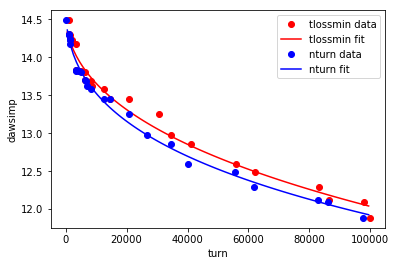

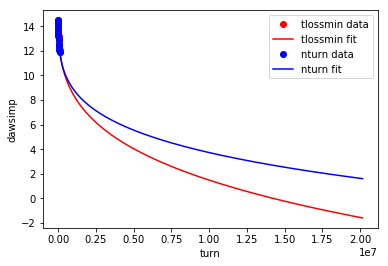

In [70]:
compare_tlossmin_nturn(d,37)

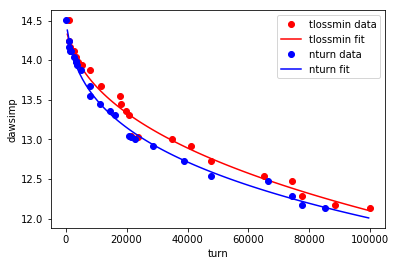

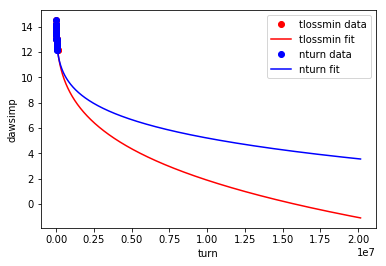

In [73]:
compare_tlossmin_nturn(d,56)

In [82]:
d.data['turnavg'] = (d.data['nturn'] + d.data['tlossmin'])/2

In [86]:
def compare_tlossmin_nturn(d,seed):
    for turns in [100000,30*60*11200]:
        d.fit(seeds=[seed])
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['tlossmin'], d.cleaned_data['dawsimp'],'ro',label='tlossmin data')
        plt.plot(x,fit,'r',label='tlossmin fit')

        d.fit(seeds=[seed],xaxis='turnavg')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['turnavg'], d.cleaned_data['dawsimp'],'go',label='turnavg data')
        plt.plot(x,fit,'g',label='turnavg fit')        
        
        d.fit(seeds=[seed],xaxis='nturn')
        x   = np.arange(500,turns,1000)
        fp  = d.fit_params[d.fit_params['seed']==seed]
        fit = davst_function(x,fp['d'].values,fp['b'].values,fp['k'].values)
        plt.plot(d.cleaned_data['nturn'], d.cleaned_data['dawsimp'],'bo',label='nturn data')
        plt.plot(x,fit,'b',label='nturn fit')
        plt.legend()
        plt.xlabel('turn')
        plt.ylabel("dawsimp")
        plt.show()

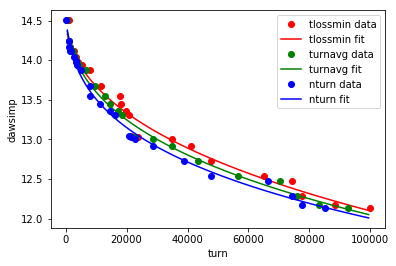

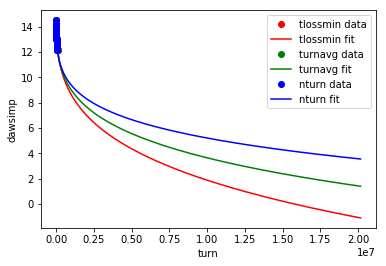

In [87]:
compare_tlossmin_nturn(d,56)

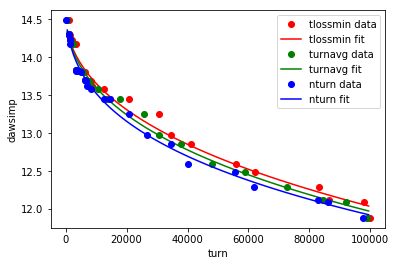

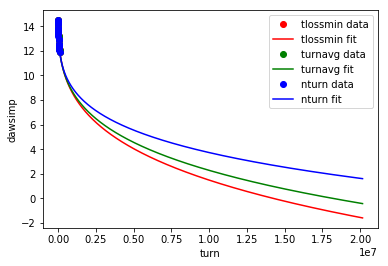

In [88]:
compare_tlossmin_nturn(d,37)

In [137]:
name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(20,40)
d    = davst(name,emit=2.5)
d.get_extrapolated_da(minutes=30)
d.data['turnavg'] = (d.data['nturn'] + d.data['tlossmin'])/2

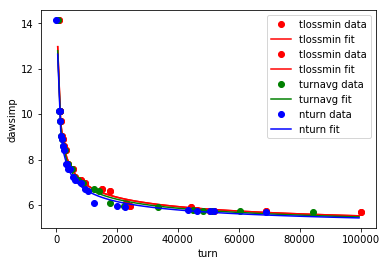

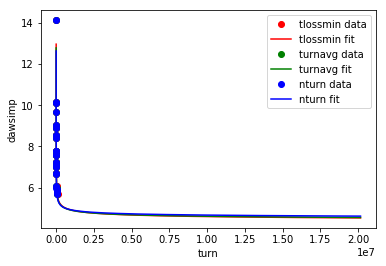

In [138]:
compare_tlossmin_nturn(d,1)

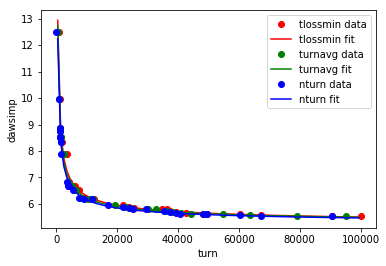

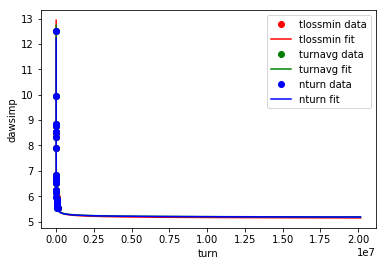

In [139]:
compare_tlossmin_nturn(d,30)

# Comparison of new and old algorithm

In [118]:
d_new = davst('/media/phermes/local/DA_studies/injection_2016/db/lhc_b1_inj_2016_qp_0_ioct_0.db',emit=3.75)
d_old = davst('/home/phermes/development/SixDeskDB/test7_newtloss_chrom-0.0-0.0.db',emit=3.75)

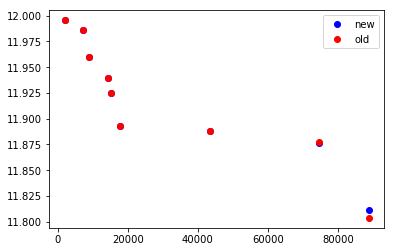

In [124]:
d_new.fit(seeds=[4])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[4])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

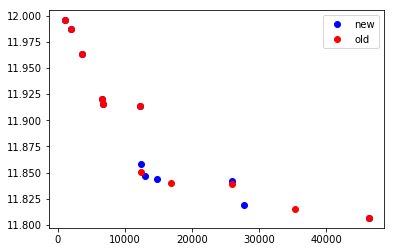

In [123]:
d_new.fit(seeds=[1])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[1])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

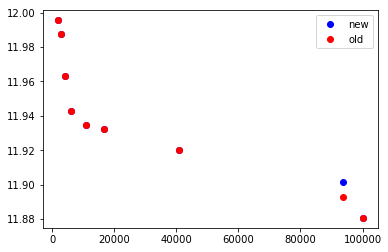

In [125]:
d_new.fit(seeds=[2])
d_new.get_extrapolated_da(minutes=30)
d_old.fit(seeds=[2])
d_old.get_extrapolated_da(minutes=30)

x = np.arange(500,100000,1000)
plt.plot(d_new.cleaned_data['tlossmin'],d_new.cleaned_data['dawsimp'],'bo',label='new')
plt.plot(d_old.cleaned_data['tlossmin'],d_old.cleaned_data['dawsimp'],'ro',label='old')
plt.legend()
plt.show()

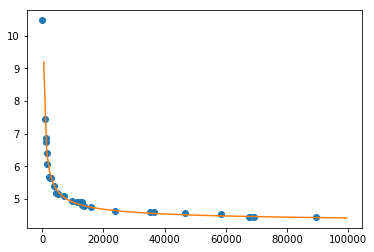

In [37]:
seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt.fit_da_kappa(k,seed,xaxis='nturn')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['nturn'],dvt.cleaned_data['dawsimp'],'o')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']))
plt.show()

In [112]:
dvt = davst('/home/phermes/development/SixDeskDB/test7_newtloss_chrom-0.0-0.0.db',emit=3.75)

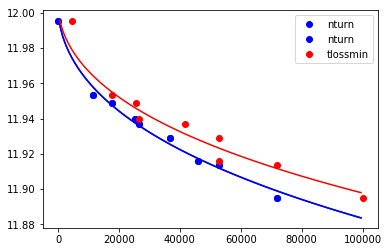

In [116]:
seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'nturn')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['nturn'],dvt.cleaned_data['dawsimp'],'bo',label='nturn')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'b')


seed = 3
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'ro',label='tlossmin')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'r')
plt.legend()
plt.show()

# Analyze Studies

## LHC 2016 Injection

In [28]:
output = []
for chroma in range(0,22,2):
    for ioct in range(0,44,4):
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d    = davst(name,emit=2.5)
        d.extrapolated_da = d.extrapolated_da[d.extrapolated_da['exda_1800_sec']>5]
        exda = d.extrapolated_da['exda_1800_sec']
        output.append([chroma, ioct, exda.min(), exda.max(), exda.mean(), exda.std()])
output = pd.DataFrame(output,columns=['chroma','ioct','damin','damax','daavg','dastd'])

In [169]:
output

,chroma,ioct,damin,damax,daavg,dastd
0,0,0,12.462194,14.554725,13.593967,0.513734
1,0,4,9.724458,14.075512,12.377945,1.006788
2,0,8,5.004214,12.134849,7.469984,1.760223
3,0,12,6.523739,11.523831,9.945940,1.023349
4,0,16,9.014565,10.921867,10.055060,0.457374
5,0,20,8.459070,11.647738,9.480691,1.222288
6,0,24,5.130444,9.176465,7.814158,0.907677
7,0,28,5.112667,8.235986,7.131352,0.780006
8,0,32,5.333714,7.922443,6.899907,0.625529
9,0,36,5.039966,7.256949,6.449910,0.587824


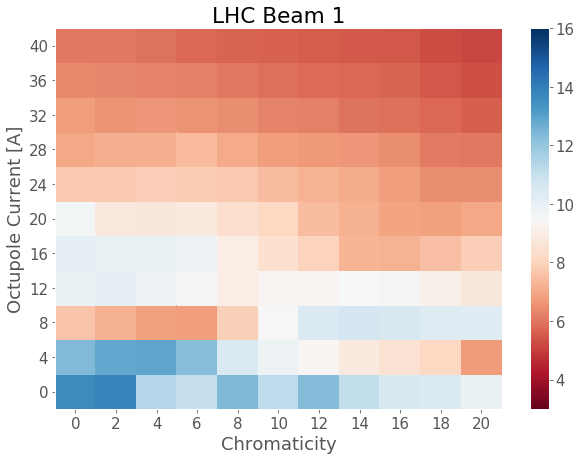

In [29]:
fig = plt.figure(figsize=[12,9])
import matplotlib
font = {'size'   : 15}
plt.style.use('ggplot')

matplotlib.rc('font', **font)

loss_lim1, loss_lim2 = 1e-3, 1e0

fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(111)            

X,Y,Z = prepare_pcolormesh(output, 'chroma','ioct','daavg',offset=[-1,-2,0])

ax1.set_title('LHC Beam 1')
ax1.set_xlabel("Chromaticity")
ax1.set_ylabel("Octupole Current [A]")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)

ax1.set_xticks(np.array(range(0,21,2)))
ax1.set_yticks(np.array(range(0,41,4)))
 
plt.show()

In [72]:
output = []
for chroma in range(0,12,2):
    for ioct in range(0,44,4):
        name = basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct)
        d    = davst(name,emit=2.5)
        d.extrapolated_da = d.extrapolated_da[d.extrapolated_da['exda_1800_sec']>5]
        exda = d.extrapolated_da['exda_1800_sec']
        output.append([chroma, ioct, exda.min(), exda.max(), exda.mean(), exda.std()])
output = pd.DataFrame(output,columns=['chroma','ioct','damin','damax','daavg','dastd'])

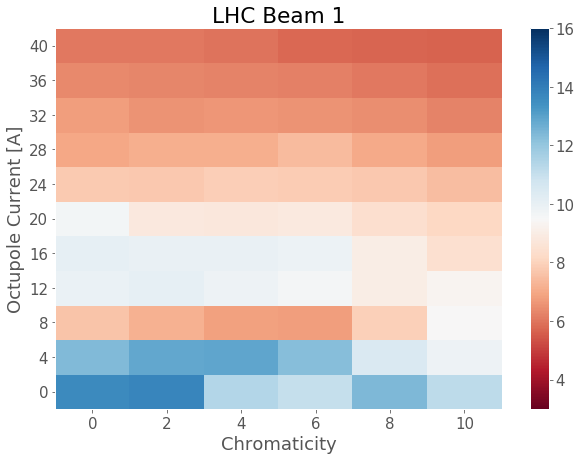

In [73]:
fig = plt.figure(figsize=[12,9])
import matplotlib
font = {'size'   : 15}
plt.style.use('ggplot')

matplotlib.rc('font', **font)

loss_lim1, loss_lim2 = 1e-3, 1e0

fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(111)            

X,Y,Z = prepare_pcolormesh(output, 'chroma','ioct','daavg',offset=[-1,-2,0])

ax1.set_title('LHC Beam 1')
ax1.set_xlabel("Chromaticity")
ax1.set_ylabel("Octupole Current [A]")

im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=3, vmax=16)
fig.colorbar(im1,ax=ax1)
# fig.colorbar(im1,label=r'Mean DA after 30min [$\sigma$]',ax=ax1)

ax1.set_xticks(np.array(range(0,12,2)))
ax1.set_yticks(np.array(range(0,41,4)))
 
plt.show()

### With monotonicity check, using tlossmin

In [26]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
d = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
d.check_monotonicity = True
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

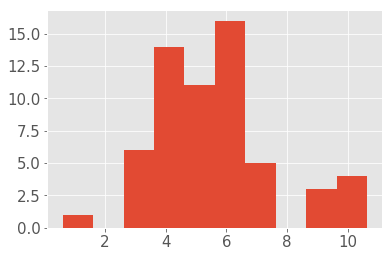

In [27]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

30min DA without monotonicity check 10.062872961
30min DA with    monotonicity check 6.50623792639


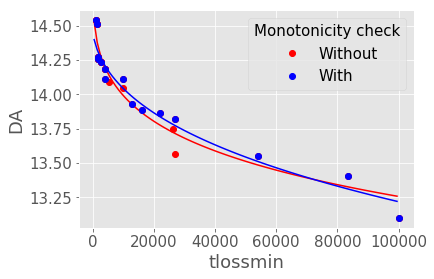

In [56]:


basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
dvt = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
dvt.check_monotonicity = False

seed = 4
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]
print('30min DA without monotonicity check', davst_function(30*60*11200,dfslice['d'],dfslice['b'],dfslice['k']))

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'ro',label='Without')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'r')



basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
dvt = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
dvt.check_monotonicity = True


seed = 4
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]
print('30min DA with    monotonicity check', davst_function(30*60*11200,dfslice['d'],dfslice['b'],dfslice['k']))

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'bo',label='With')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'b')

plt.xlabel("tlossmin")
plt.ylabel("DA")
plt.legend(title='Monotonicity check')
plt.show()

### Without monotonicity check, using tlossmin

In [18]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
d = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
d.check_monotonicity = False
d.fit(save=False)
d.get_extrapolated_da(minutes=30,save=False)

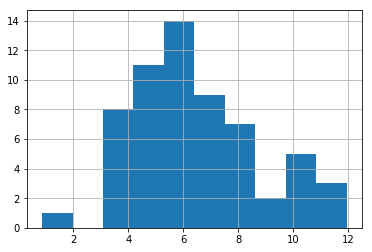

In [19]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

6.50623792639


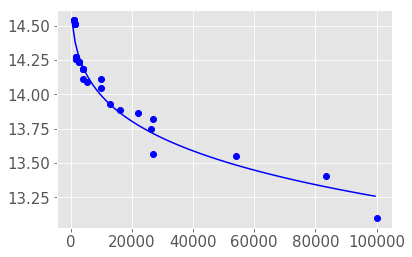

In [48]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
dvt = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
dvt.check_monotonicity = False

print(davst_function(30*60*11200,dfslice['d'],dfslice['b'],dfslice['k']))

seed = 4
output = []

for k in np.arange(-5,5,0.1):
    d,b,kappa,chisq,derr,berr = dvt._fit_da_single_kappa(k,seed,'tlossmin')
    output.append([d,b,kappa,chisq,derr,berr])
output = pd.DataFrame(output,columns=['d','b','k','chi','derr','berr'])

indx_bestfit = output['chi'].argmin()    # index of the best fit
dfslice      = output.iloc[indx_bestfit]

x = np.arange(500,100000,1000)
plt.plot(dvt.cleaned_data['tlossmin'],dvt.cleaned_data['dawsimp'],'bo',label='tlossmin')
plt.plot(x,davst_function(x,dfslice['d'],dfslice['b'],dfslice['k']),'b')
plt.show()

### With monotonicity check, using nturn

In [22]:
basedir = '/media/phermes/local/DA_studies/injection_2016/db/'
chroma, ioct = 4,8
d = davst(basedir+"lhc_b1_inj_2016_qp_{0}_ioct_{1}.db".format(chroma,ioct),emit=2.5)
d.check_monotonicity = True
d.fit(save=False,xaxis='nturn')
d.get_extrapolated_da(minutes=30,save=False)

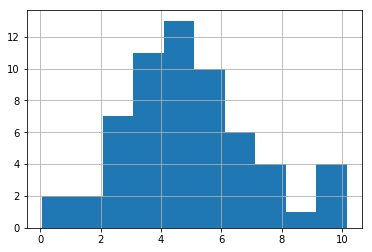

In [23]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

## ATS Injection 2017

In [4]:
basedir = '/media/phermes/local/DA_studies/ats2017/b1/analysis/'

In [6]:
chroma, ioct = 0,0
d = davst(basedir+"ats2017_b1_QP_{0}_IOCT_{1}.db".format(chroma,ioct),emit=2.5)
d._min_datapoints = 5
d.check_monotonicity = True
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

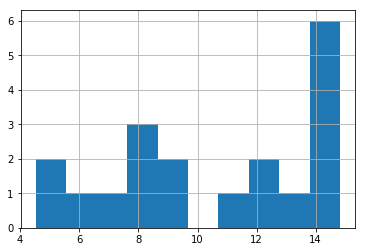

In [7]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

In [8]:
chroma, ioct = 0,0
d = davst(basedir+"ats2017_b1_QP_{0}_IOCT_{1}.db".format(chroma,ioct),emit=2.5)
d._min_datapoints = 5
d.check_monotonicity = False
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

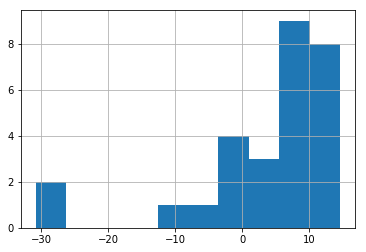

In [9]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

In [10]:
chroma, ioct = 0,0
d = davst(basedir+"ats2017_b1_QP_{0}_IOCT_{1}.db".format(chroma,ioct),emit=2.5)
d._min_datapoints = 5
d.check_monotonicity = False
d.fit(save=True,xaxis='nturn')
d.get_extrapolated_da(minutes=30,save=True)

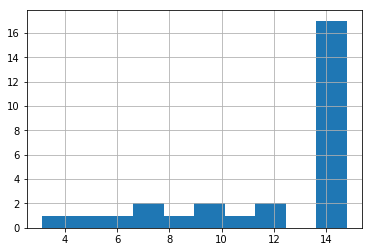

In [11]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()

In [13]:
d.extrapolated_da['exda_1800_sec'].mean()

12.07525516768425

In [183]:
chroma, ioct = 20,40
d = davst(basedir+"ats2017_b1_QP_{0}_IOCT_{1}.db".format(chroma,ioct),emit=2.5)
# d._min_datapoints = 5
d.fit(save=True)
d.get_extrapolated_da(minutes=30,save=True)

/home/phermes/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


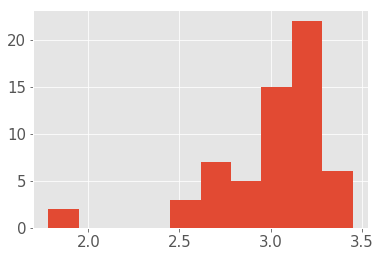

In [184]:
d.extrapolated_da['exda_1800_sec'].hist()
plt.show()